IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

Wszystko oprócz R to będą slidery, albo pola tekstowe [TODO]

In [2]:
ALPHA = 0.5
NUMBER_OF_EMITERS = 360
DETECTORS = 360

L = 100

im = cv2.imread("Kropka.jpg", 0)

R = min(im.shape)

algorytm Bresenhama [DO OPTYMALIZACJI (TFU)]

In [3]:
def bresenhamLine(x1, y1, x2, y2):
    d,dx,dy,ai,bi,xi,yi = (0,)*7
    x,y = x1,y1
    
    coords = [(x1,y1)]
    
    if (x1 < x2):
        xi =1
        dx = x2 - x1
    else:
        xi = -1
        dx = x1 - x2
    
    if (y1 < y2):
        yi = 1
        dy = y2 - y1
    else:
        yi = -1
        dy = y1 - y2
    
    if (dx > dy):
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
        
        while (x != x2):
            if (d >= 0):
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                x += xi
            coords.append((x, y))
    else:
        ai = (dx - dy) * 2
        bi = dx * 2
        d = bi - dy
        
        while (y != y2):
            if (d >=0):
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                y += yi
            coords.append((x, y))
    coords.append((x2,y2))
    return coords

Te dwie komórki niżej są wprost ze wzoru http://www.cs.put.poznan.pl/swilk/pmwiki/uploads/Dydaktyka/tomograf-wzory.pdf

\+ jest wyśrodkowane czyli +R/2 na x i y, bo OpenCV tak bierze coordy:

0,0 - - - ->X<br>
|<br>
|<br>
|<br>
v<br>
Y<br>

In [4]:
def getEmiterPosition(r, alpha):
    x = r * np.cos( np.radians(alpha)) + R/2
    y = r * np.sin( np.radians(alpha)) + R/2
    return (int(x),int(y))

In [5]:
def getSensorPosition(r, alpha, fi, i, numberOfSensors):
    x = r * np.cos (np.radians(alpha) + np.pi - np.radians(fi)/2 + i * ( np.radians(fi) / (numberOfSensors-1) )) + R/2
    y = r * np.sin (np.radians(alpha) + np.pi - np.radians(fi)/2 + i * ( np.radians(fi) / (numberOfSensors-1) )) + R/2
    return (int(x),int(y))

def getAllSensors(r, alpha, fi, numberOfSensors):
    sensors = []
    for i in range(numberOfSensors):
        sensors.append(getSensorPosition(r, alpha, fi, i, numberOfSensors))
    return sensors

In [6]:
"""
Sinogram X -> sensor
         Y -> emiter
         
         To jest zrobione addytywnie, ale nie wiem czy to dobrze działa, trzeba sprawdzić
"""

def sinogram(r, fi, noe, image):
    
    sinogram = np.zeros([DETECTORS,NUMBER_OF_EMITERS])
    
    
    for i in range(NUMBER_OF_EMITERS):
        emiter = getEmiterPosition(r, ALPHA * i)
        sensors = getAllSensors(r, ALPHA * i, L, DETECTORS)
        for j,sensor in enumerate(sensors):
            misc = 0
            for coord in  bresenhamLine(emiter[0],emiter[1],sensor[0],sensor[1]):
                misc += image[coord[0]-1][coord[1]-1]
            sinogram[j][i] += misc
    sinogram = sinogram / np.amax(sinogram)
    plt.imshow(sinogram, cmap='gray')
    

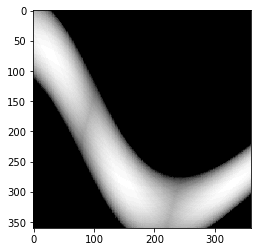

In [7]:
sinogram(R/2, 180, 360, im)